In [1]:
from firedrake import *
import numpy as np
import matplotlib . pyplot as plt
import time


firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
## DISCLAIMER: we are assuming here that the flow is 2D, i.e. we are neglecting the effect of the width of the channel,
## In the 3D bulk flow the solution is constant in the width direction (we neglect boundary layer in this direction)
## W has been imposed to gain Re ~ 1000, which is in the theoretical limit for laminar flow (5772, from Orr-Sommerfeld stability analysis)

L = 0.05          # Length of the channel, m
H = 0.004         # Height of the channel, m
W = 0.028005618   # Width of the channel, m. Assuming the original flow stems for 3D flow channel between wide plates very near each other
t = 0.001         # Thickness of the channel, m

inlet_flow = (1/60.0)*1e-3 # Inlet flow rate, m^3/s10
T_in = Constant(293.15)     # Inlet temperature, K
q_ = 1e5       # Heat flux, W/m^2
rho_f = 997       # Density of the fluid, kg/m^3
mu_f = 8.9e-4     # Dynamic viscosity of the fluid, Pa.s
k_f = 0.6       # Thermal conductivity of the fluid, W/m.K
c_pf = 4182       # Specific heat capacity of the fluid, J/kg.K
k_s = 400         # Thermal conductivity of the solid, W/m.K

# Non-dimensionalization through {H, U}. We define the velocity inlet from Poiseuille flow profile 
# u(y) = 4U_max/H^2 * (y - 0.001) * (0.005 - y). Knowing flux at inlet we get U_max. We find U_max using the Poiseuille result:

U = 1.5 * inlet_flow / (H*W)  # Average velocity, m/s

print(U)

# We nondimensionalize NS and we define Re = rho_f * U * H / mu_f

Re = rho_f * U * H / mu_f
print(Re)






0.2231695083465039
999.9999991975928


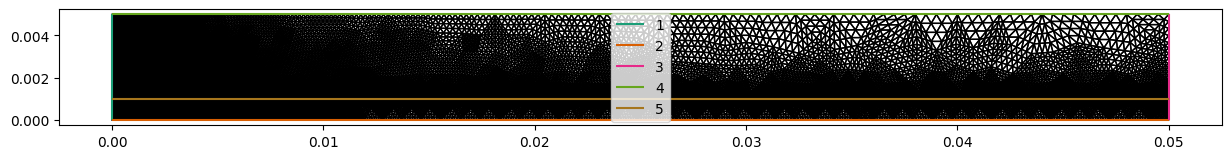

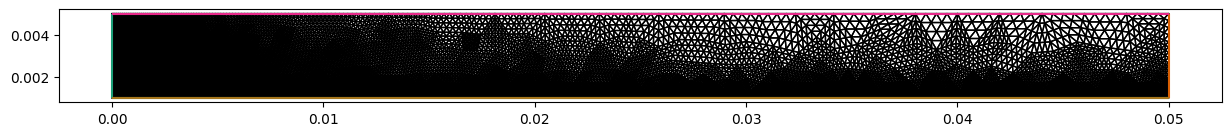

In [3]:
# Loading of the mesh
mesh = Mesh("CHT-model/Mesh_Scripts/mesh_corintis.msh")

fig, ax = plt.subplots(figsize=(15, 6))
triplot(mesh, axes=ax)
ax.set_aspect("equal")
ax.legend(loc='center')

#Define the cell_tags according to Gmsh file and extract submesh for fluid region
fluid = 200
solid = 100
M = FunctionSpace(mesh, "DG", 0)
indicator_function = Function(M)
indicator_function.assign(1, subset=mesh.cell_subset(fluid))
relabeled_mesh = RelabeledMesh(mesh, [indicator_function], [fluid])
submesh = Submesh(relabeled_mesh, mesh.topological_dimension(), fluid)
fig, ax = plt.subplots(figsize=(15,6))
triplot(submesh, axes=ax)
#ax.legend(loc='center')
ax.set_aspect("equal")



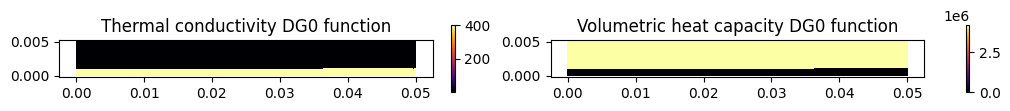

In [4]:
# Define piecewise thermal conductivity k and volumetric heat capacity rho*cp
k = Function(M)
k.assign(k_f, subset=mesh.cell_subset(fluid))   
k.assign(k_s, subset=mesh.cell_subset(solid))   

# Volumetric heat capacity (rho * cp) piecewise
rho_cp = Function(M)
rho_cp.assign(rho_f*c_pf, subset=mesh.cell_subset(fluid))  

fig, axes = plt.subplots(1, 2, figsize=(10, 1), constrained_layout=True)

# Primo plot: k
tpc1 = tripcolor(k, axes=axes[0], cmap="inferno")
fig.colorbar(tpc1, ax=axes[0])
axes[0].set_aspect("equal")
axes[0].set_title("Thermal conductivity DG0 function")

# Secondo plot: rho*cp
tpc2 = tripcolor(rho_cp, axes=axes[1], cmap="inferno")
fig.colorbar(tpc2, ax=axes[1])
axes[1].set_aspect("equal")
axes[1].set_title("Volumetric heat capacity DG0 function")

plt.show()

In [5]:
# Function spaces. Mixed formulation for velocity and pressure + scalar field space for temperature
V = VectorFunctionSpace(submesh, 'CG', 2)
print(V.dim())

Q = FunctionSpace(submesh, 'CG', 1)
W = MixedFunctionSpace([V, Q])
# temperature space on the whole mesh
Z = FunctionSpace(mesh, 'CG', 2)        

#Define Test and Trial functions
u, p = TrialFunctions(W)
v, q = TestFunctions(W)
T = TrialFunction(Z)
eta = TestFunction(Z)

# Define the boundary conditions for both problems: notice the parabolic profile is fully adimensional (set coeff at 1 for simplicity) 
x = SpatialCoordinate(submesh)
#u_in = ((6/(H*H))*(x[1] - 0.001)*(-x[1] + 0.005), 0.0)
u_in = ((1 - ((x[1] - 0.003)*(x[1] - 0.003))/(0.002*0.002)), 0.0)


# No slip on walls for velocity   
bc_wall_up = DirichletBC(W.sub(0), Constant((0.,0.)), 4)
bc_wall_fs = DirichletBC(W.sub(0), Constant((0.,0.)), 6)
# Inlet velocity profile
bc_in = DirichletBC(W.sub(0), u_in, 1)
bcs = (bc_wall_up, bc_wall_fs, bc_in)
bcT_in = DirichletBC(Z, T_in, 1)
#Define normal to the bigger geometry for Neumann BCs
n = FacetNormal(mesh)



84506


In [6]:

def initialization_problem_forms(u, v, p, q):
    a_stokes = (1.0/Re)*inner(grad(u), grad(v))*dx - div(v) * p * dx + q * div(u) * dx
    L_stokes = 0.0
    return a_stokes, L_stokes

def nonlinear_iteration_forms(u, v, p, q, u_old):
    a_Newton = (1.0/Re)*inner(grad(u), grad(v))*dx \
        + dot(dot(grad(u), u_old), v) * dx \
        + dot(dot(grad(u_old), u), v) * dx \
        - div(v) * p * dx \
        + q * div(u) * dx \

    L_Newton = dot(dot(grad(u_old), u_old), v) * dx
    return a_Newton, L_Newton

def picard_forms(u, v, p, q, u_old):
    a_Picard = (1.0/Re)*inner(grad(u), grad(v))*dx \
        + dot(dot(grad(u), u_old), v) * dx \
        - div(v) * p * dx \
        + q * div(u) * dx \

    L_Picard = 0.0
    return a_Picard, L_Picard

def nonlinear_iteration_thermal(T, eta, u):
    a = k*inner(grad(T), grad(eta))*dx \
      + (rho_cp) * dot(u, grad(T)) * eta * dx
    L = q_ * eta * ds(2, domain=mesh)
    return a, L

def thermal_supg(T, eta, uh):

    ubar = Function(FunctionSpace(mesh, 'DG', 0))
    ubar.project(sqrt(inner(uh, uh)))
    h = CellDiameter(mesh)
    delta_K = Function(ubar.function_space())
    delta_K = 10.0 * h / (ubar+1e-5)

    a = k * inner(grad(T), grad(eta)) * dx  \
        + (rho_cp) * inner(grad(T), uh) * eta * dx \
        + (delta_K * inner(uh, grad(T)) ) * \
            ((rho_cp) * inner(uh, grad(eta))) * dx
    L = q_ * eta * ds(2, domain=mesh)

    return a, L




""" def supg_forms(u, v, p, q, u_old, delta):
    # coefficient delta_K
    ubar = Function(FunctionSpace(submesh, 'DG', 0)) 
    ubar.project(sqrt(inner(u_old, u_old)))
    h = CellDiameter(submesh)
    Re_K = h * ubar * Re
    one  = Constant(1.0)
    delta_K = delta * conditional(gt(Re_K, one),  h/(ubar+1e-5), h*h*Re) 
    print(norm(delta_K), flush=True)

    # SUPG-stabilization of Newton iteration
    lhs_NewtonSUPG = delta_K * inner(
            -2/Re*div(sym(grad(u)))
                + dot(grad(u_old), u)
                + dot(grad(u), u_old)
                + grad(p)
            ,
            dot(skew(grad(u_old)), v)
            + dot(grad(v), u_old) + 0.5*div(u_old)*v
            + grad(q)
            ) * dx \
            + delta_K * div(u) * div(v) * dx
    rhs_NewtonSUPG = delta_K * inner(
            dot(grad(u_old), u_old)
            ,
            dot(skew(grad(u_old)), v)
            + dot(grad(v), u_old) + 0.5*div(u_old)*v
            + grad(q)
            ) * dx

    # return lhs_fpSUPG, rhs_fpSUPG
    return lhs_NewtonSUPG, rhs_NewtonSUPG """

def supg_forms(u, v, p, q, u_old, delta):
    # coefficient delta_K
    ubar = Function(FunctionSpace(submesh, 'DG', 0)) # piece-w lin Function
    ubar.project(sqrt(inner(u_old, u_old)))
    h = CellDiameter(submesh)
    Re_K = h * ubar * Re
    one  = Constant(1.0)
    delta_K = delta * conditional(gt(Re_K, one),  h/(ubar+1e-5), h*h*Re) 
    print(norm(delta_K), flush=True)

    lhs_fpSUPG = delta_K * inner(
            -1.0/Re*div(grad(u)) 
                + dot(grad(u), u_old) + 0.5*div(u_old)*u
                + grad(p)
            ,
            + dot(grad(v), u_old) + 0.5*div(u_old)*v
            + grad(q)
            ) * dx \
            + delta_K * div(u) * div(v) * dx
    rhs_fpSUPG = 0

    return lhs_fpSUPG, rhs_fpSUPG



/home/dave/venv-firedrake/lib/python3.10/site-packages/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(
firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


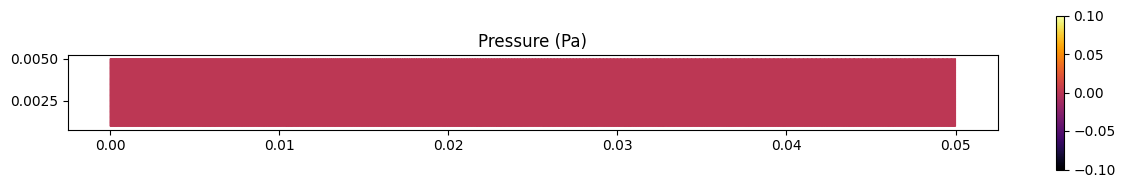

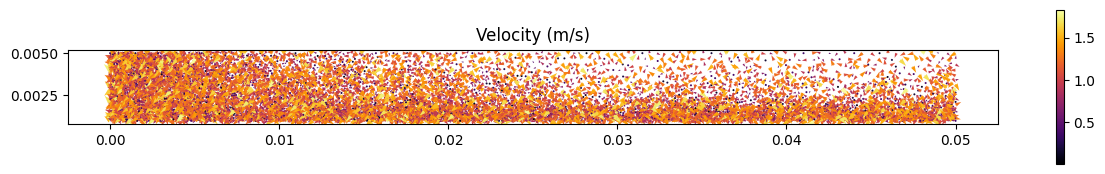

In [7]:
outfileU = File("CHT-model/output/velocity.pvd")        
outfileP = File("CHT-model/output/pressure.pvd")
outfileT = File("CHT-model/output/temperature.pvd")


# Initialization solver NS
wh_init = Function(W)
a_init, L_init = initialization_problem_forms(u, v, p, q)
# Define nullspace to eliminate the singularity of the Stokes problem
nullsp = MixedVectorSpaceBasis(W, [W.sub(0), VectorSpaceBasis(constant=True)])
init_problem = LinearVariationalProblem(a_init, L_init, wh_init, bcs)
#param = {'ksp_type': 'gmres', 'pc_type': 'bjacobi', 'sub_pc_type': 'ilu'}
param = {'ksp_type': 'preonly', 'pc_type': 'lu', 'pc_factor_mat_solver_type': 'mumps'}
solver_init =  LinearVariationalSolver(init_problem, solver_parameters=param, nullspace=nullsp)
# Actual initialization
solver_init.solve()
uh, ph = wh_init.subfunctions

wh_init = Function(W)
uh, ph = wh_init.subfunctions

#Fill `uh` with random noise between -0.5 and 0.5
np.random.seed(42)  # Optional: for reproducibility
uh.dat.data[:] = np.random.uniform(-1.3, 1.3, size=uh.dat.data.shape)

# Assign initial guess for first Newton iteration
u_old = Function(V)
u_old.assign(uh)


# Assign initial guess for first Newton iteration
u_old = Function(V)
u_old.assign(uh)    
p_old = Function(Q)
p_old.assign(ph)



Th = Function(Z)
# Initial guess is isothermal field at T_in
Th.interpolate(T_in)

# Plot of initial guess (Stokes solution)
fig, ax = plt.subplots(figsize=(15, 2))
col = tripcolor(ph, axes=ax, cmap="inferno")
ax.set_aspect("equal")
plt.colorbar(col)
plt.title('Pressure (Pa)')
fig, ax = plt.subplots(figsize=(15, 2))
col = quiver(uh, axes=ax, cmap="inferno")
ax.set_aspect("equal")
plt.colorbar(col)
plt.title('Velocity (m/s)')

# Initial files for post-processing
uh.rename("Velocity (m/s)")
ph.rename("Pressure (Pa)")
Th.rename("Temperature (K)")

outfileU.write(uh)
outfileP.write(ph)
outfileT.write(Th)

a, L = nonlinear_iteration_forms(u, v, p, q, u_old)
#a, L = picard_forms(u, v, p, q, u_old)
#a_supg, L_supg = supg_forms(u, v, p, q, u_old, Constant(1.0))
#a, L = supg_forms(u, v, p, q, u_old, Constant(0.1))
wh = Function(W)
problem = LinearVariationalProblem(a, L, wh, bcs)
solver =  LinearVariationalSolver(problem, solver_parameters=param, nullspace=nullsp)



In [8]:

#Actual NS Newton solver
maxit = 500
it = 0
tol = 1e-6
err = tol+1     

start_time = time.time()
iteration_check = 5  # After this many iterations, print timing
printed_time = False  # Track if we've already printed

while it <= maxit and err > tol:

    it += 1

    solver.solve()
    uh, ph = wh.subfunctions
    err = errornorm(uh, u_old, 'H1') / norm(u_old, 'H1')

    print("Iteration = ", it, " Error = ", err)
    uh.rename("Velocity (m/s)")
    ph.rename("Pressure (Pa)")
    outfileU.write(uh)
    outfileP.write(ph)

    # Print timing after 5 iterations
    if it == iteration_check and not printed_time:
        elapsed = time.time() - start_time
        print(f"⏱️ Time elapsed after {iteration_check} iterations: {elapsed:.2f} seconds")
        printed_time = True

    u_old.assign(uh) # update the old solution
    p_old.assign(ph) # update the old solution

if it <= maxit:
    print('Nonlinear solver converged in', it, 'iterations.')
else:
    print('Nonlinear solver di NOT converge!\nRelative error =', err, 'after', it, 'iterations.')


Iteration =  1  Error =  1.0002707915796125
Iteration =  2  Error =  0.635004982398151
Iteration =  3  Error =  0.006424754287942954
Iteration =  4  Error =  1.6623686285934652e-06
Iteration =  5  Error =  3.981921064992551e-13
⏱️ Time elapsed after 5 iterations: 15.42 seconds
Nonlinear solver converged in 5 iterations.


In [9]:
V_mesh = VectorFunctionSpace(mesh, "CG", 2)
uh = uh *U
ph.assign(ph * rho_f * U * U)  # Dimensional pressure
uh_mesh = Function(V_mesh).interpolate(uh, allow_missing_dofs=True)
a_T, L_T = thermal_supg(T, eta, uh_mesh)
pb_T = LinearVariationalProblem(a_T, L_T, Th, bcT_in)
solver_T =  LinearVariationalSolver(pb_T)#, solver_parameters=param)
solver_T.solve()
Th.rename("Temperature (K)")
outfileT.write(Th)

Text(0.5, 1.0, 'Temperature (K)')

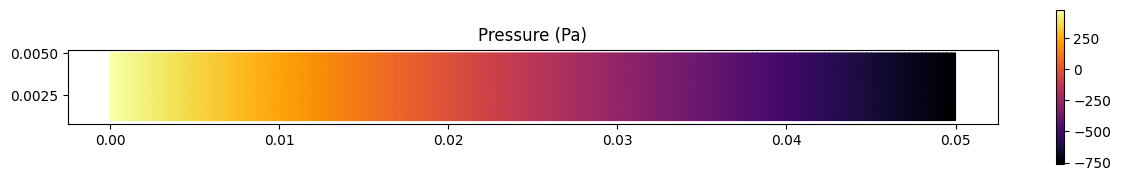

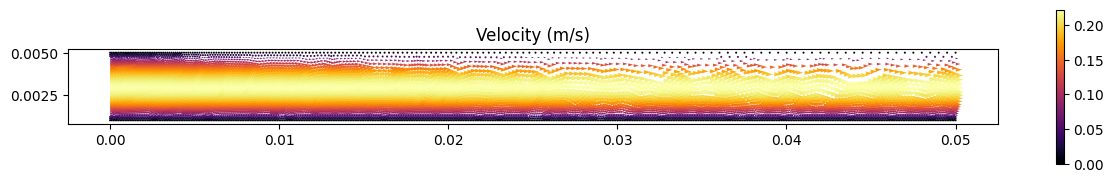

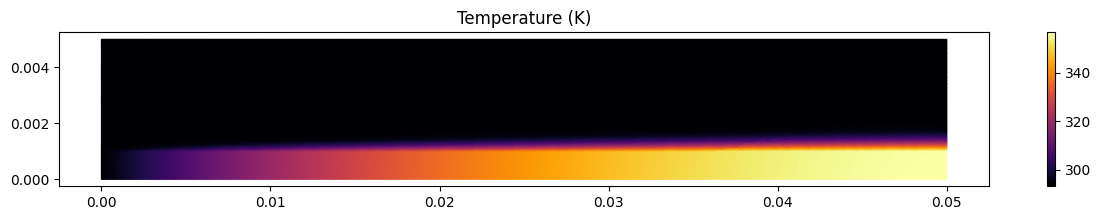

In [10]:
# Final plots
fig, ax = plt.subplots(figsize=(15, 2))
col = tripcolor(ph, axes=ax, cmap="inferno")
ax.set_aspect("equal")
plt.colorbar(col)
plt.title('Pressure (Pa)')
fig, ax = plt.subplots(figsize=(15, 2))
col = quiver(uh, axes=ax, cmap="inferno")
ax.set_aspect("equal")
plt.colorbar(col)
plt.title('Velocity (m/s)')
fig, ax = plt.subplots(figsize=(15, 2))
col = tripcolor(Th, axes=ax, cmap="inferno")
#ax.set_aspect("equal")
plt.colorbar(col)
plt.title('Temperature (K)')


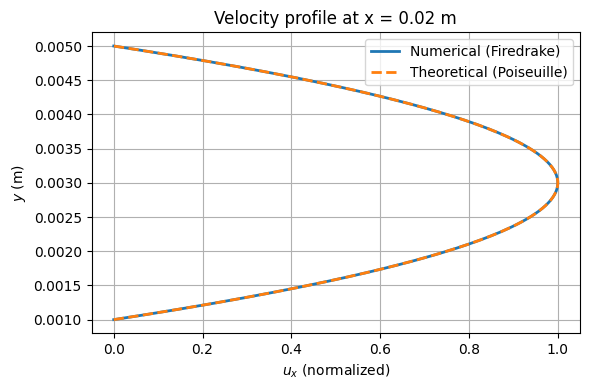

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from firedrake import *

# Interpolate uh into a Function if it's symbolic
uh = Function(V).interpolate(uh)

# Define vertical line at fixed x
x_fixed = 0.02  # Choose any x in domain
y_vals = np.linspace(0.001, 0.005, 200)  # y range of the channel

# Evaluate u_x from numerical solution
ux_vals = []
for y in y_vals:
    pt = (x_fixed, y)
    u_vec = uh.at(pt, tolerance=1e-10)
    ux_vals.append(u_vec[0])  # x-component

# Convert to numpy array for further manipulation
ux_vals = np.array(ux_vals)

# Normalize numerical solution
ux_vals_norm = ux_vals / U

# === Theoretical solution ===
H = 0.004           # Channel height
y_c = 0.003         # Centerline
u_theory = 1 - ((y_vals - y_c) / (H / 2))**2  # Normalized theoretical profile

# === Plotting ===
plt.figure(figsize=(6, 4))
plt.plot(ux_vals_norm, y_vals, label="Numerical (Firedrake)", linewidth=2)
plt.plot(u_theory, y_vals, '--', label="Theoretical (Poiseuille)", linewidth=2)
plt.xlabel("$u_x$ (normalized)")
plt.ylabel("$y$ (m)")
plt.title(f"Velocity profile at x = {x_fixed} m")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show() 